In [1]:
!pwd
!ls

/home/ubuntu/cases/src
check.py	     liver		    predict.py	     stomach.csv
colon		     liver.csv		    prostate	     thyroid
gen_miRNA_matrix.py  lung		    README.md	     uterus
kidney		     lung.csv		    request_meta.py  uterus.csv
Lab 10.ipynb	     parse_file_case_id.py  stomach	     utils


In [2]:
import os 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook

df_stomach = pd.read_csv(os.getcwd() + "/stomach.csv")
df_lung = pd.read_csv(os.getcwd() + "/lung.csv")
df_liver = pd.read_csv(os.getcwd() + "/liver.csv")
df_uterus = pd.read_csv(os.getcwd() + "/uterus.csv")

frames = [df_stomach, df_lung, df_liver, df_uterus]

df = pd.concat(frames, ignore_index=True)

df.dropna(axis=0) # drop rows with at least one NA
df.dropna(axis=1) # drop cols with at least one NA

df.loc[df['label'] == 1, 'label'] = 'cancerous'
df.loc[df['label'] == 0, 'label'] = 'benign'

df['y'] = df['Primary Site'] + ' ' + df['label']
#y_data = df[['Primary Site', 'label']].copy()

df.head()

,Unnamed: 0,file_id,hsa-let-7a-1,hsa-let-7a-2,hsa-let-7a-3,hsa-let-7b,hsa-let-7c,hsa-let-7d,hsa-let-7e,hsa-let-7f-1,...,hsa-mir-944,hsa-mir-95,hsa-mir-9500,hsa-mir-96,hsa-mir-98,hsa-mir-99a,hsa-mir-99b,label,Primary Site,y
0,0,71e4a642-f657-4cbd-a20c-4a645a80cf93,39714,39416,39839,52899,4871,2313,4894,21614,...,1,22,0,57,188,854,42713,cancerous,stomach,stomach cancerous
1,1,f10d08db-57ae-4dc0-af92-0e65a6fbf016,14738,14867,15110,22137,589,3506,911,8407,...,2,9,0,112,122,208,41395,cancerous,stomach,stomach cancerous
2,2,29000285-6eae-4213-9c43-6f2ad593cdb7,52757,53050,52786,48321,4841,1515,5402,32363,...,0,12,0,19,189,1113,26646,cancerous,stomach,stomach cancerous
3,3,cee4b1e6-571c-4e23-81d9-14793065ee78,23216,23291,23457,33474,430,2168,2008,14316,...,6,20,0,184,169,127,31265,cancerous,stomach,stomach cancerous
4,4,96d9b38b-3694-4fd5-94cd-1479575df959,16502,16500,16703,24320,1304,1673,2227,6232,...,5,20,0,35,99,499,83560,cancerous,stomach,stomach cancerous


In [3]:
y_data = df['y'].copy()
df.pop('y')
#y_data = pd.get_dummies(y_data, drop_first=True)

#from sklearn.preprocessing import OneHotEncoder
#ohe = OneHotEncoder(categorical_features=[0])
#ohe.fit_transform(y_data).toarray()

df.pop('label')
df.pop('Primary Site')
df.pop('file_id')
df.pop('Unnamed: 0')
X_data = df.values.astype('float64', copy=False)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=0)

k=5 Nearest Neighbors: 
                    precision    recall  f1-score   support

     liver benign       0.71      0.89      0.79        19
  liver cancerous       0.84      0.77      0.81       127
      lung benign       0.75      0.69      0.72        13
   lung cancerous       0.82      0.72      0.77       146
   stomach benign       0.80      0.92      0.86        13
stomach cancerous       0.72      0.73      0.72       127
    uterus benign       0.60      0.75      0.67         4
 uterus cancerous       0.64      0.75      0.69       112

      avg / total       0.76      0.75      0.75       561



/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


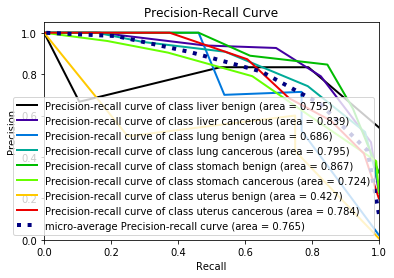

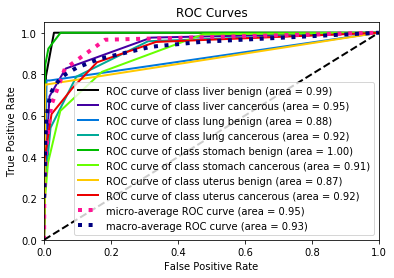

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = make_pipeline(StandardScaler(),
                         KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))

pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)

from sklearn.metrics import classification_report

print('k=5 Nearest Neighbors: \n', classification_report(y_true=y_test, y_pred=y_pred))

import scikitplot as skplt
skplt.metrics.plot_precision_recall_curve(y_test, pipe_knn.predict_proba(X_test))
skplt.metrics.plot_roc(y_test, pipe_knn.predict_proba(X_test))

In [15]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator=pipe_knn, X=X_train, y=y_train, cv=5, n_jobs=1)
print('CV accuracy scores: %s' % scores)

CV accuracy scores: [0.86792453 0.86742424 0.84351145 0.87356322 0.82490272]


## Feature Selection via Random Forest Classifier

<IPython.core.display.Javascript object>


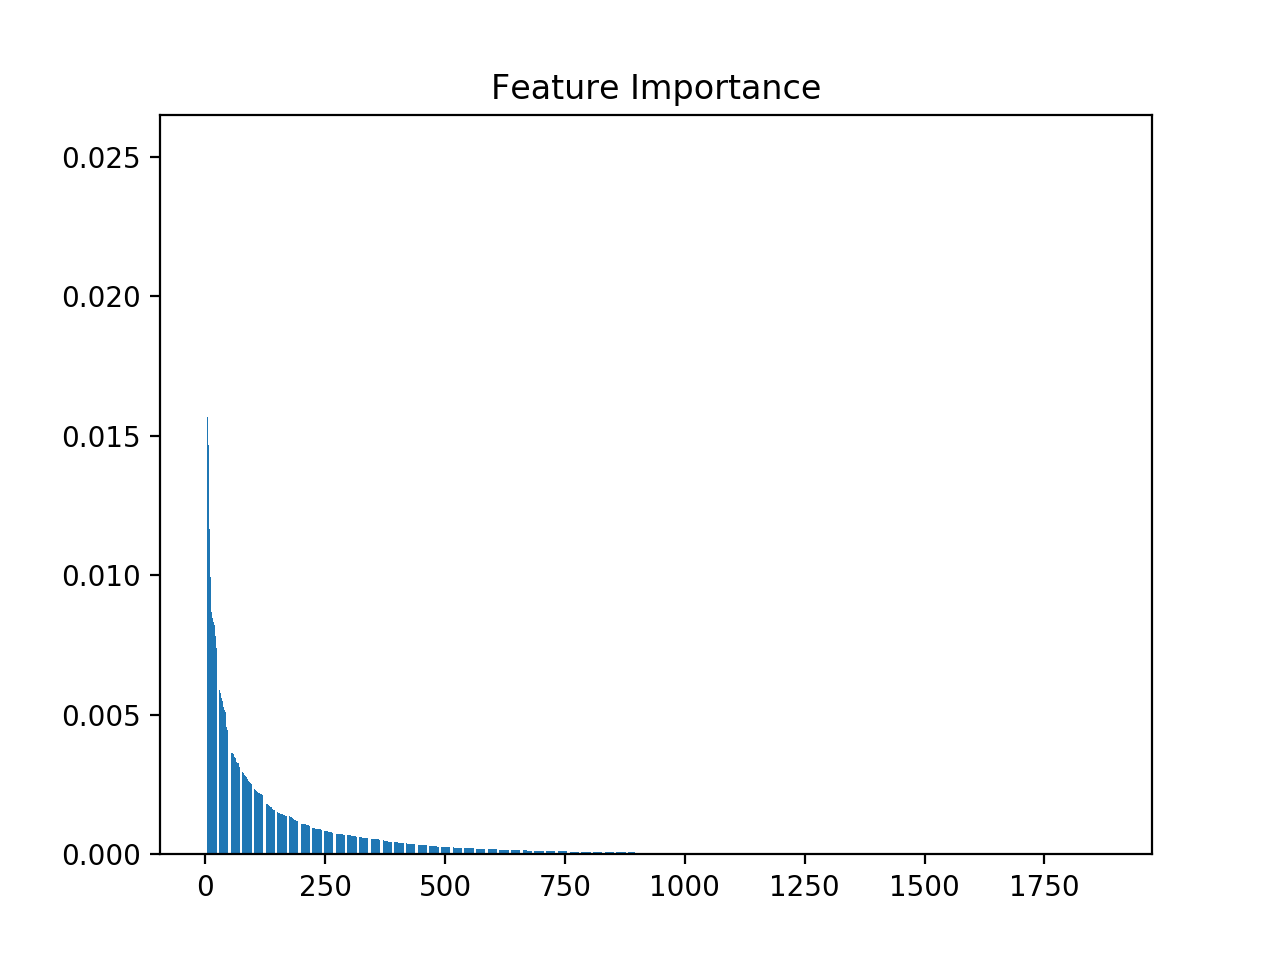

<BarContainer object of 1881 artists>

In [40]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=500, random_state=1)
forest.fit(X_train, y_train)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
columns = df.columns # original imported csv dataframe

%matplotlib notebook
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')

In [37]:
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, columns[indices[f]], importances[indices[f]]))

 1) hsa-mir-194-2                  0.025219
 2) hsa-mir-194-1                  0.018835
 3) hsa-mir-885                    0.018080
 4) hsa-mir-192                    0.017793
 5) hsa-mir-196b                   0.017455
 6) hsa-mir-215                    0.015681
 7) hsa-mir-205                    0.015238
 8) hsa-mir-122                    0.014672
 9) hsa-mir-10b                    0.012187
10) hsa-mir-200c                   0.011646
11) hsa-mir-141                    0.011381
12) hsa-mir-1295b                  0.009928
13) hsa-mir-9-3                    0.008797
14) hsa-mir-200a                   0.008694
15) hsa-mir-511                    0.008568
16) hsa-mir-429                    0.008481
17) hsa-mir-139                    0.008401
18) hsa-mir-135b                   0.008336
19) hsa-mir-5589                   0.008287
20) hsa-mir-3591                   0.008207
21) hsa-mir-203b                   0.008091
22) hsa-mir-9-1                    0.007840
23) hsa-mir-449a                

In [17]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

pipe_knn = make_pipeline(StandardScaler(),
                         #SelectFromModel(LassoCV(), threshold=0),
                         SelectFromModel(RandomForestClassifier(n_estimators=1000, threshold=0.001),
                         KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))

# sorted(pipe_knn.get_params().keys())

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=[{'selectfrommodel__estimator__n_estimators': [10, 50, 100, 500, 1000]}],
                  scoring='accuracy',
                  cv=5)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9365928189457601
{'selectfrommodel__estimator__n_estimators': 1000}


k=5 Nearest Neighbors: 
                    precision    recall  f1-score   support

     liver benign       0.90      1.00      0.95        19
  liver cancerous       0.98      0.94      0.96       127
      lung benign       0.77      0.77      0.77        13
   lung cancerous       0.92      0.92      0.92       146
   stomach benign       0.79      0.85      0.81        13
stomach cancerous       0.91      0.96      0.93       127
    uterus benign       0.75      0.75      0.75         4
 uterus cancerous       1.00      0.95      0.97       112

      avg / total       0.94      0.94      0.94       561



/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


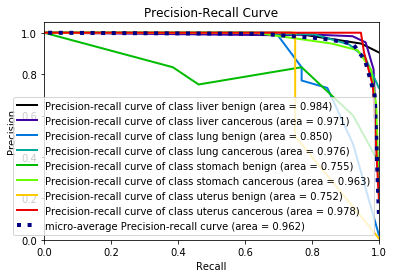

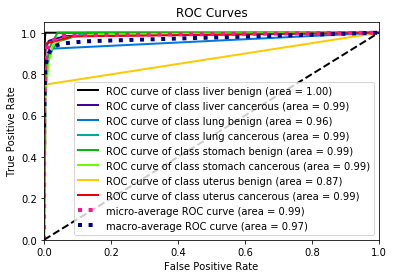

In [18]:
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)

print('k=5 Nearest Neighbors: \n', classification_report(y_true=y_test, y_pred=y_pred))

skplt.metrics.plot_precision_recall_curve(y_test, pipe_knn.predict_proba(X_test))
skplt.metrics.plot_roc(y_test, pipe_knn.predict_proba(X_test))

<IPython.core.display.Javascript object>


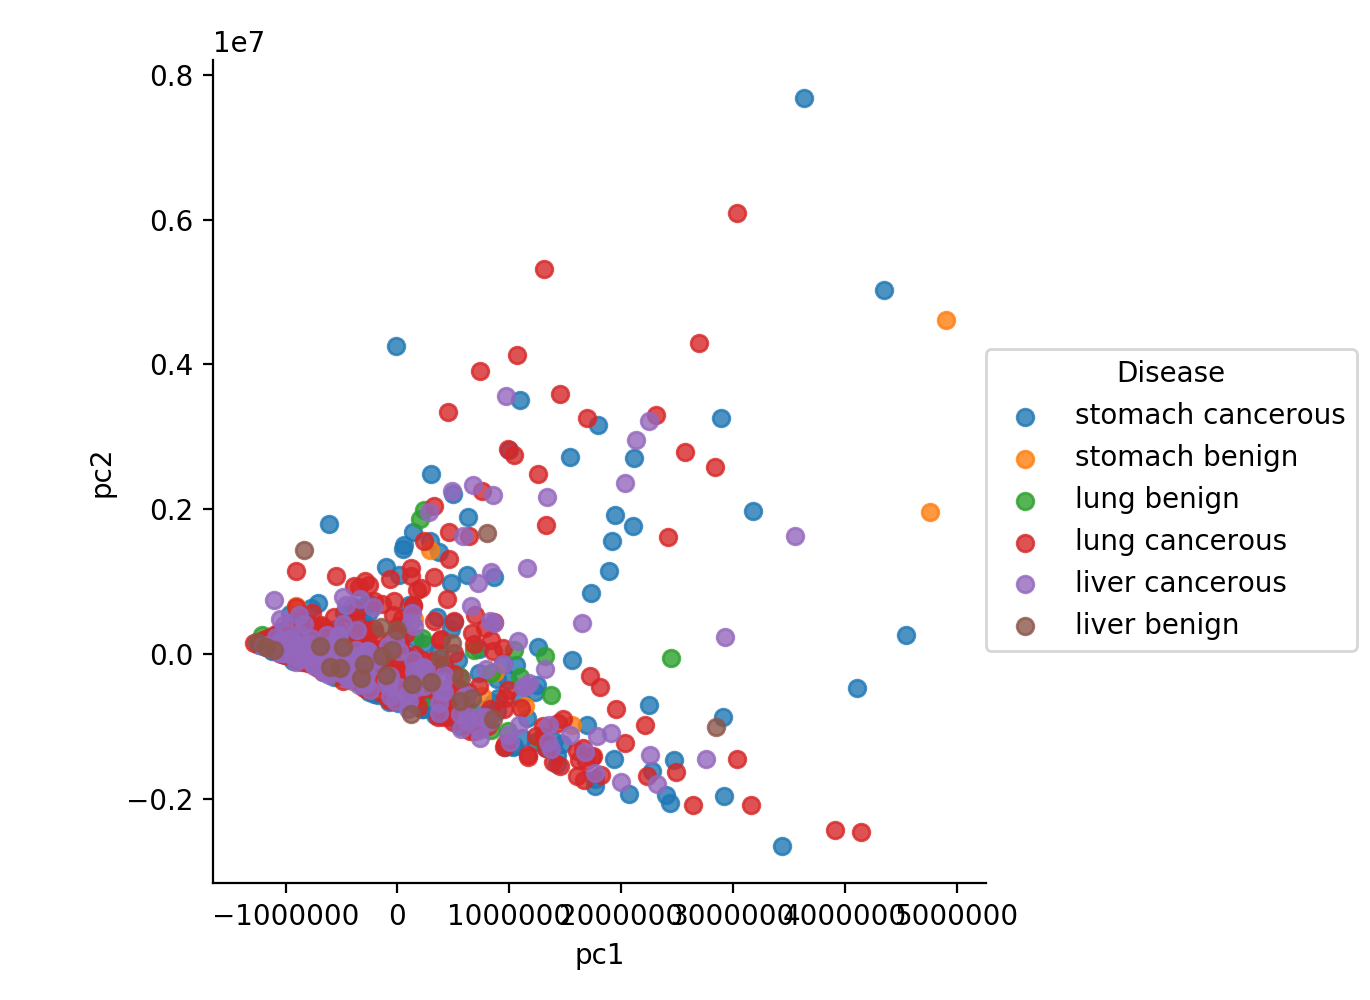

<IPython.core.display.Javascript object>


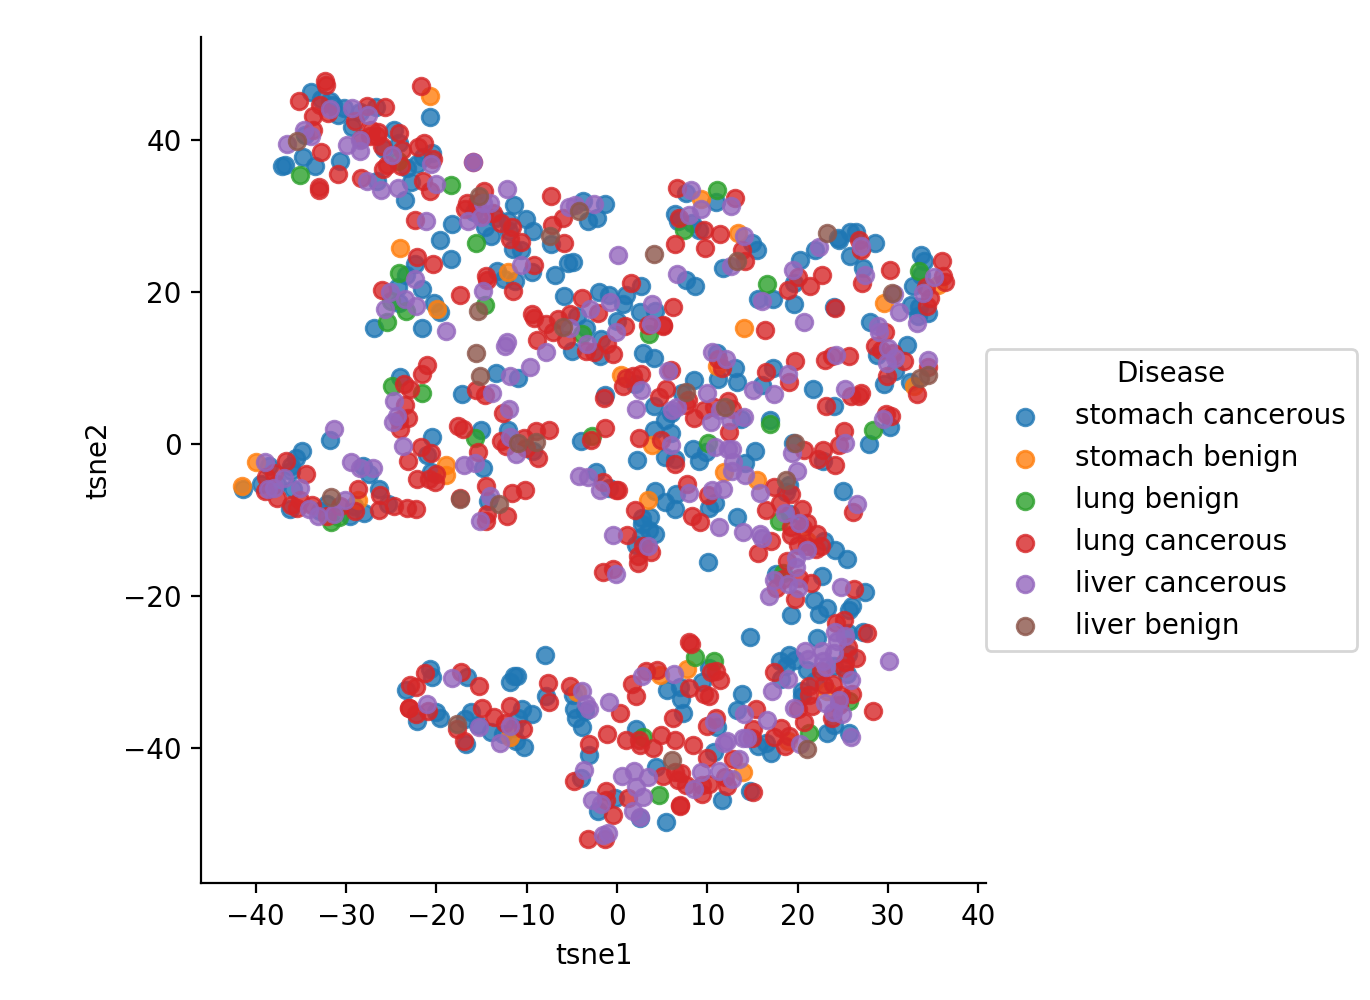

<IPython.core.display.Javascript object>


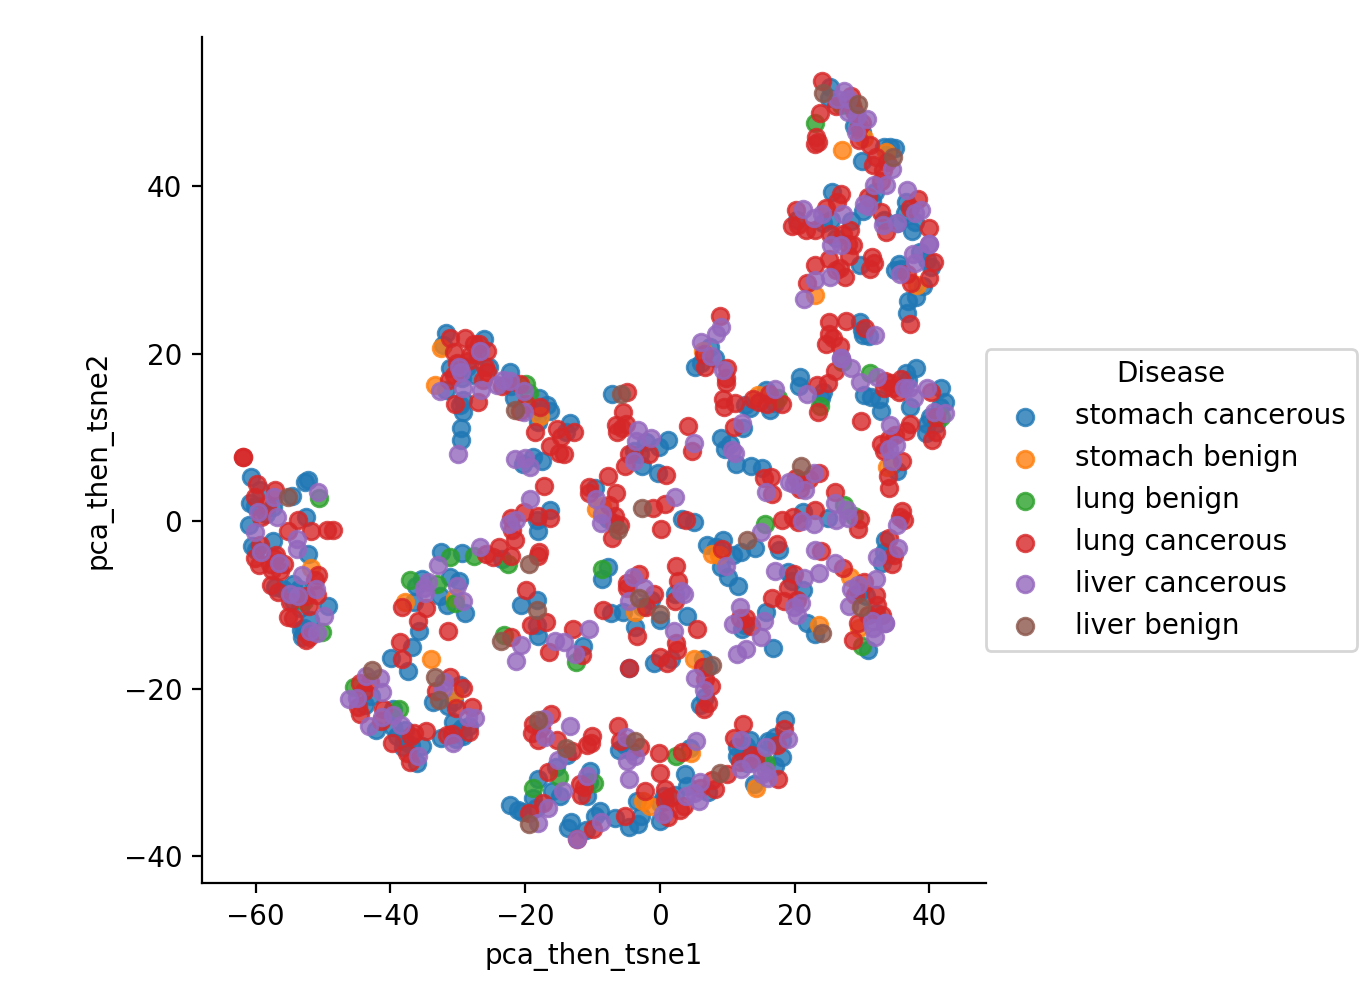

In [29]:
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components = 2).fit_transform(X_train)
tsne = TSNE(learning_rate=200).fit_transform(X_train)
pca_then_tsne = TSNE(learning_rate=200).fit_transform(pca)
mds = MDS(n_components = 2).fit_transform(X_train)
iso = Isomap(n_components = 2).fit_transform(X_train)

df_pca = pd.DataFrame(data = pca , columns = ['pc1', 'pc2'])
df_pca['Disease'] = y_train
sns.lmplot(x='pc1', y='pc2', data=df_pca, fit_reg=False, hue='Disease', legend=True)

df_tsne = pd.DataFrame(data = tsne , columns = ['tsne1', 'tsne2'])
df_tsne['Disease'] = y_train
sns.lmplot(x='tsne1', y='tsne2', data=df_tsne, fit_reg=False, hue='Disease', legend=True)

df_pca_then_tsne = pd.DataFrame(data = pca_then_tsne , columns = ['pca_then_tsne1', 'pca_then_tsne2'])
df_pca_then_tsne['Disease'] = y_train
sns.lmplot(x='pca_then_tsne1', y='pca_then_tsne2', data=df_pca_then_tsne, fit_reg=False, hue='Disease', legend=True)

<IPython.core.display.Javascript object>


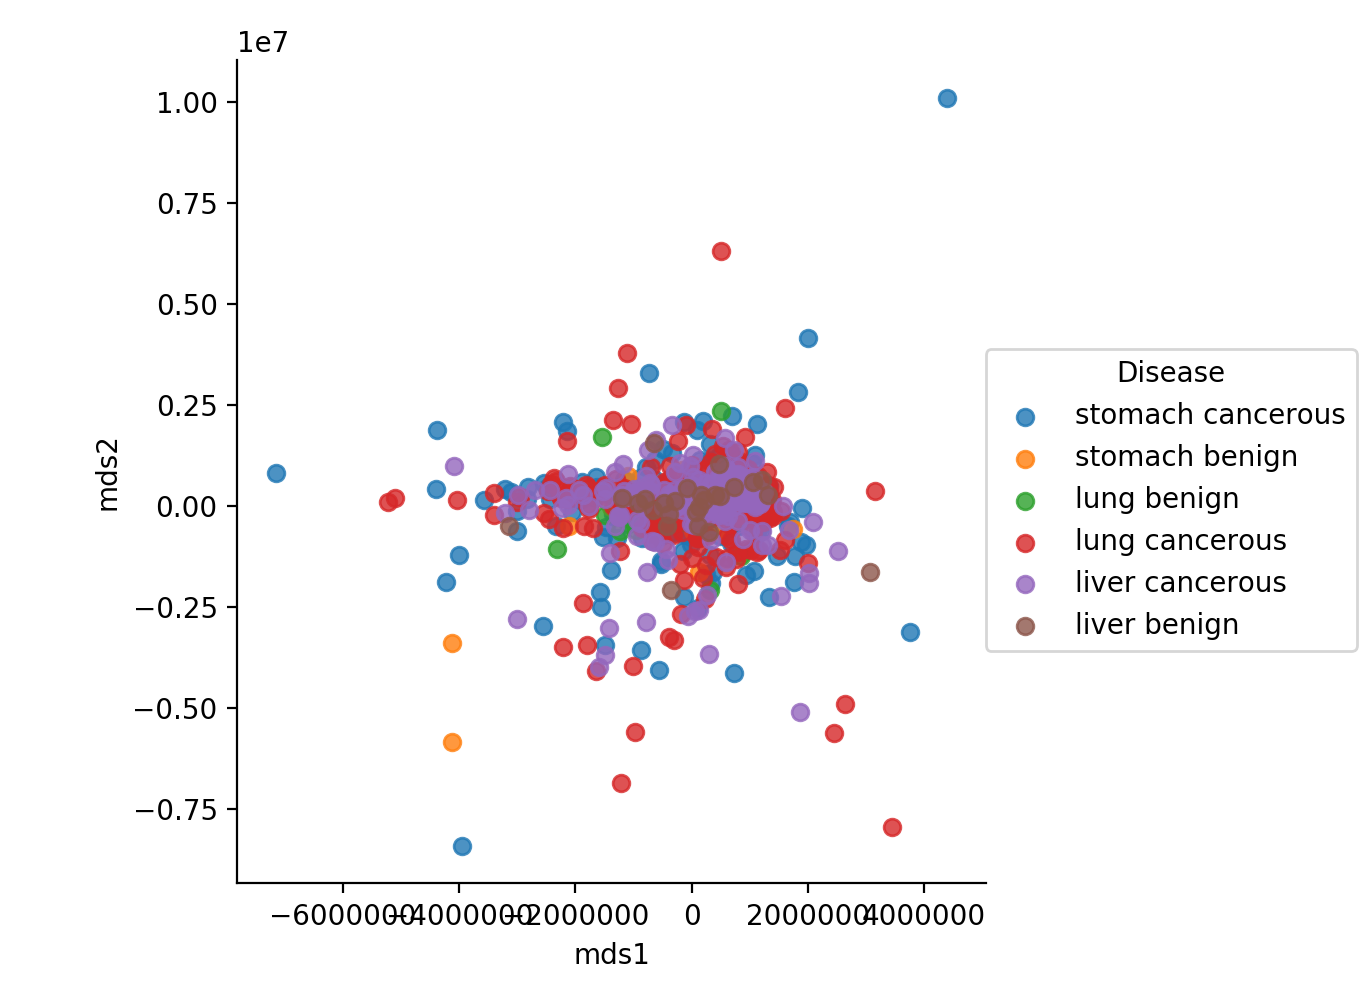

<IPython.core.display.Javascript object>


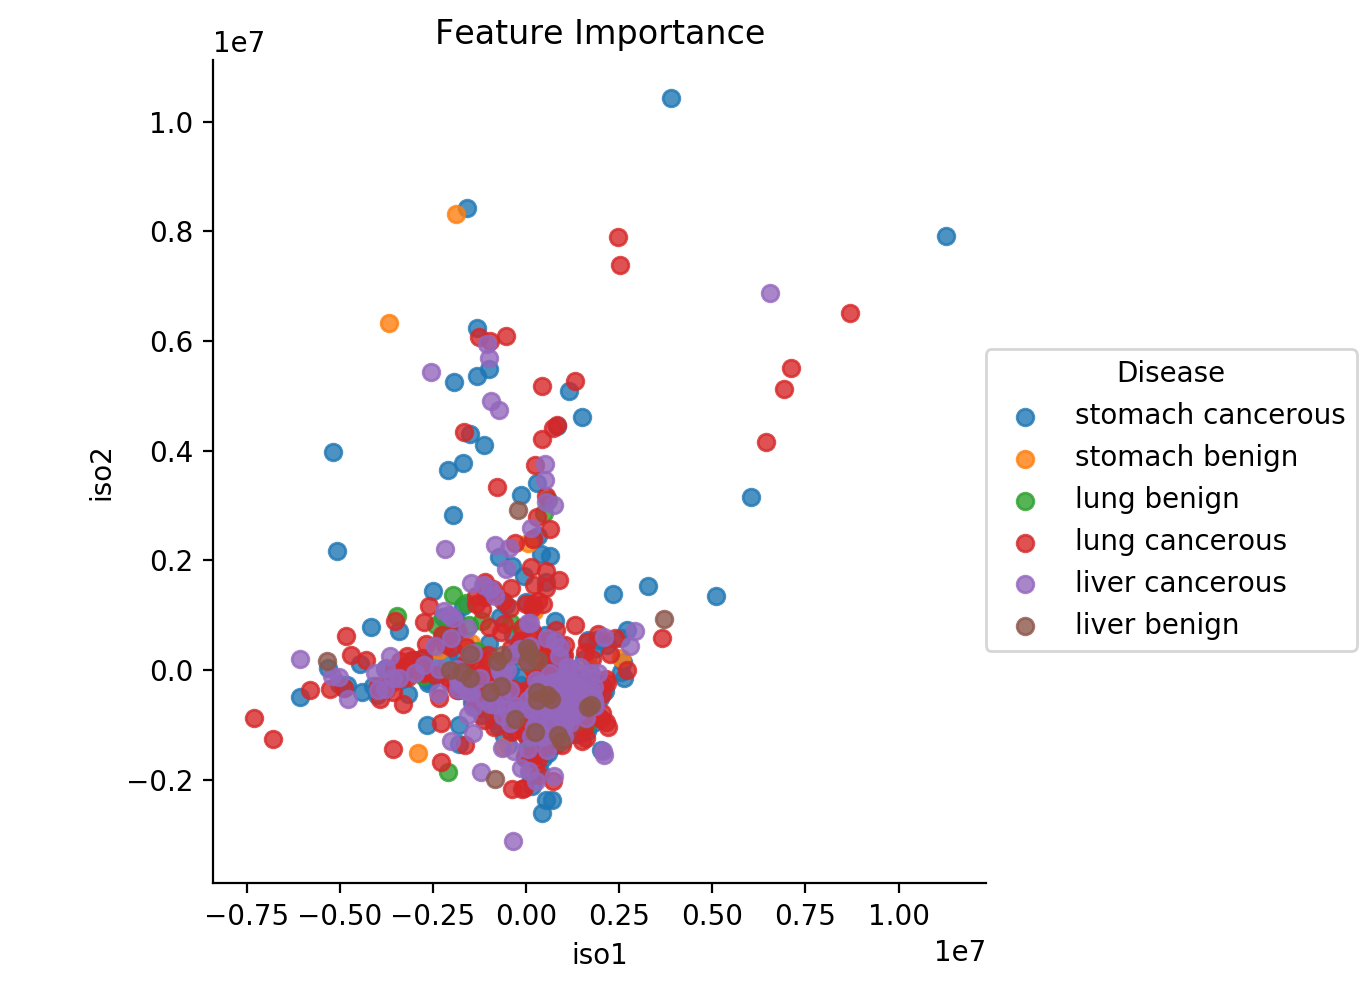

In [30]:
df_mds = pd.DataFrame(data = mds , columns = ['mds1', 'mds2'])
df_mds['Disease'] = y_train
sns.lmplot(x='mds1', y='mds2', data=df_mds, fit_reg=False, hue='Disease', legend=True)

df_iso = pd.DataFrame(data = iso , columns = ['iso1', 'iso2'])
df_iso['Disease'] = y_train
sns.lmplot(x='iso1', y='iso2', data=df_iso, fit_reg=False, hue='Disease', legend=True)

In [19]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.pipeline import Pipeline

pipe_knn = Pipeline([
    ('scale', StandardScaler()),
    ('feature selection', SelectFromModel(RandomForestClassifier(n_estimators=1000), threshold=0.001)),
    ('reduce_dim', PCA()),
    ('classifier', KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))
])

param_grid = [
    {
        'reduce_dim': [PCA(), Isomap(), TruncatedSVD()],
        'reduce_dim__n_components': [2, 3],
    },
]

gs = GridSearchCV(estimator=pipe_knn,
                  param_grid=param_grid,
                  scoring='accuracy',
                  cv=5)

gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)


0.8846447669977082
{'reduce_dim': Isomap(eigen_solver='auto', max_iter=None, n_components=3, n_jobs=1,
    n_neighbors=5, neighbors_algorithm='auto', path_method='auto', tol=0), 'reduce_dim__n_components': 3}


k=5 Nearest Neighbors: 
                    precision    recall  f1-score   support

     liver benign       0.75      0.63      0.69        19
  liver cancerous       0.90      0.89      0.90       127
      lung benign       0.52      0.85      0.65        13
   lung cancerous       0.90      0.86      0.88       146
   stomach benign       0.71      0.38      0.50        13
stomach cancerous       0.87      0.97      0.91       127
    uterus benign       1.00      0.25      0.40         4
 uterus cancerous       0.98      0.96      0.97       112

      avg / total       0.89      0.89      0.89       561



/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>


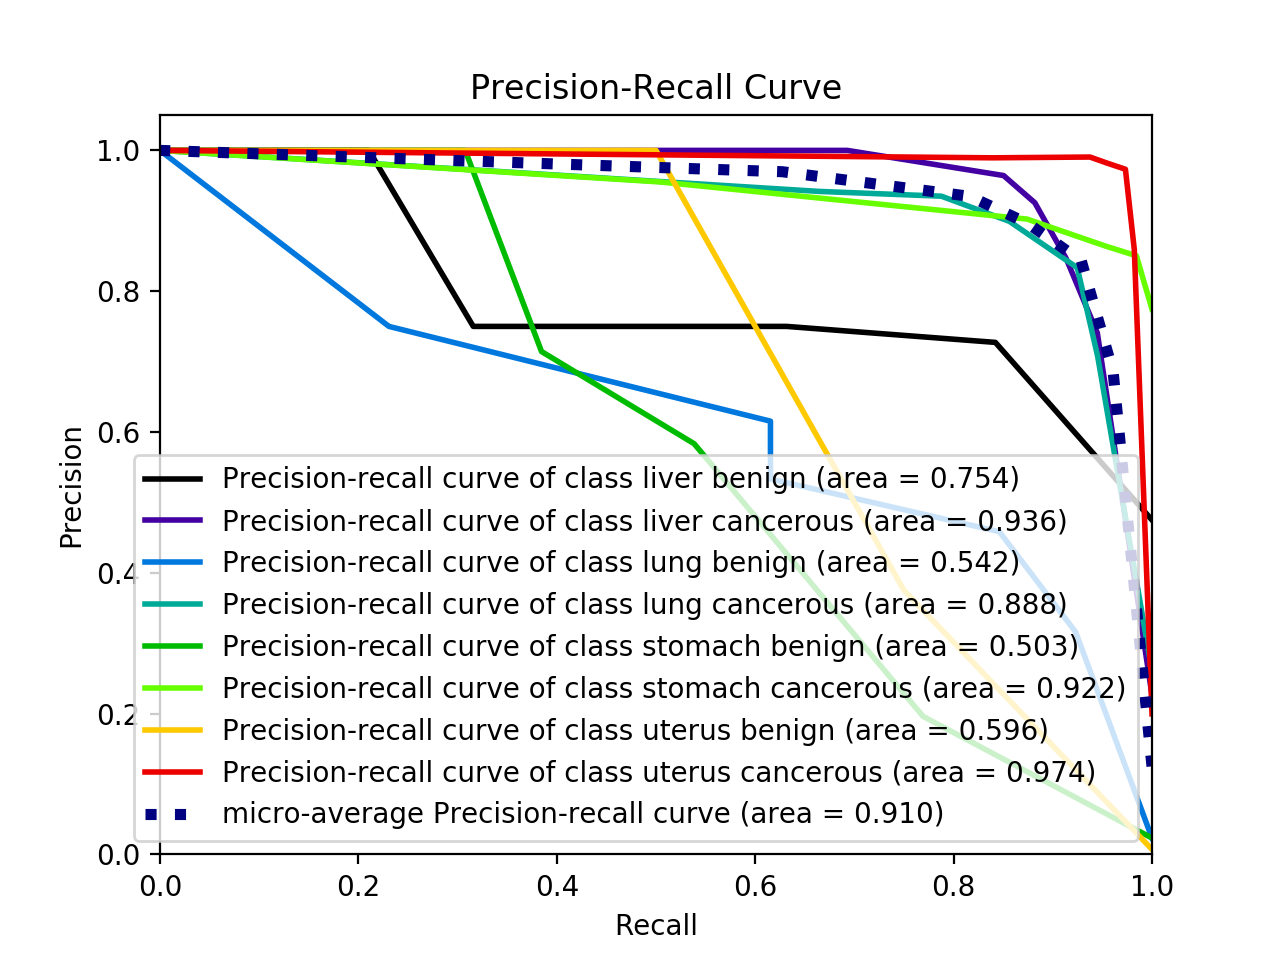

<IPython.core.display.Javascript object>


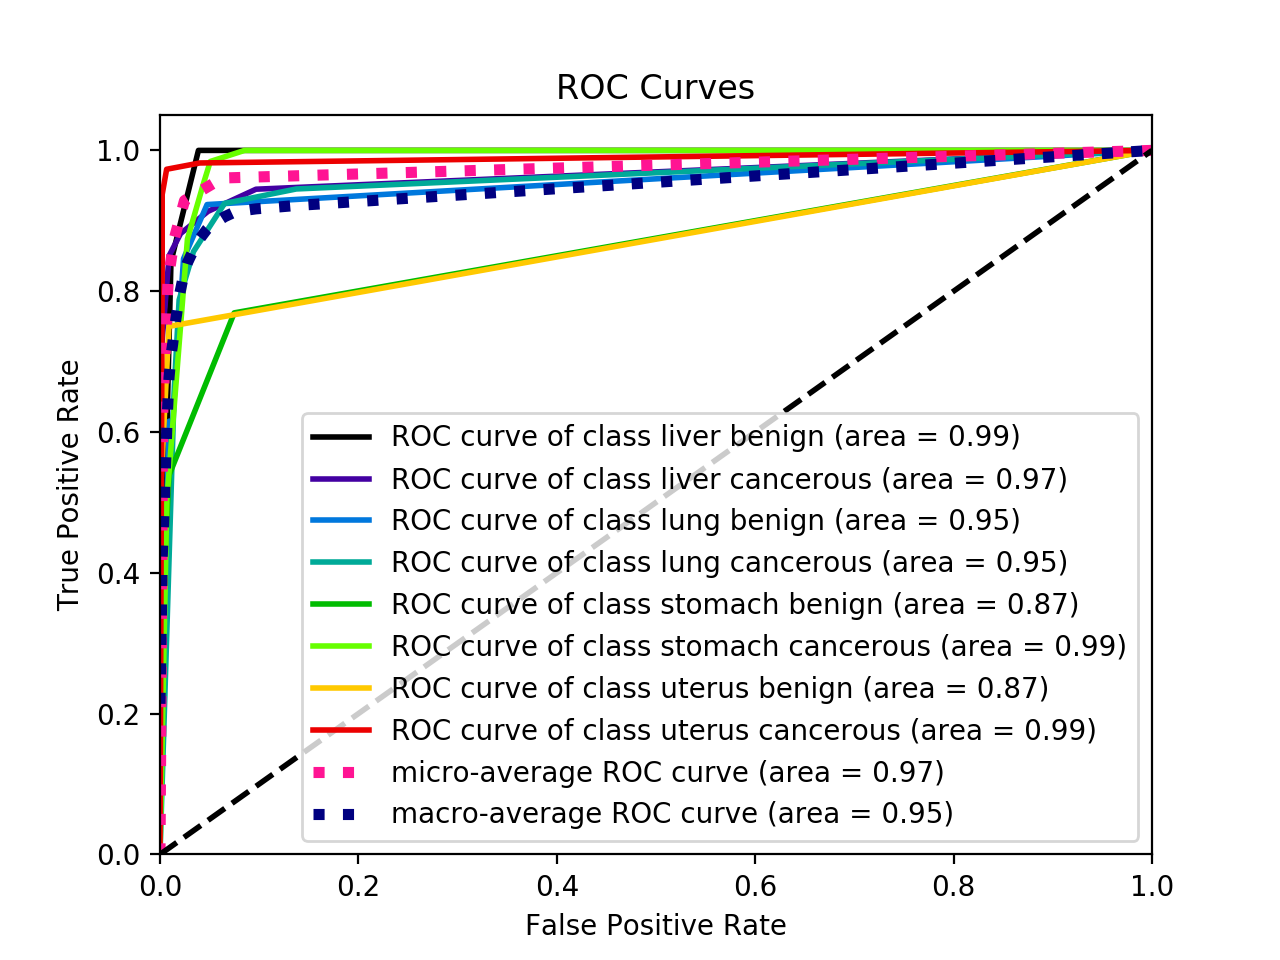

In [28]:
pipe_knn = make_pipeline(StandardScaler(),
                         SelectFromModel(RandomForestClassifier(n_estimators=1000), threshold=0.001),
                         Isomap(eigen_solver='auto', max_iter=None, n_components=3, n_jobs=1,
                                n_neighbors=5, neighbors_algorithm='auto', path_method='auto', tol=0),
                         KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))

pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)

print('k=5 Nearest Neighbors: \n', classification_report(y_true=y_test, y_pred=y_pred))

skplt.metrics.plot_precision_recall_curve(y_test, pipe_knn.predict_proba(X_test))
skplt.metrics.plot_roc(y_test, pipe_knn.predict_proba(X_test))

<IPython.core.display.Javascript object>


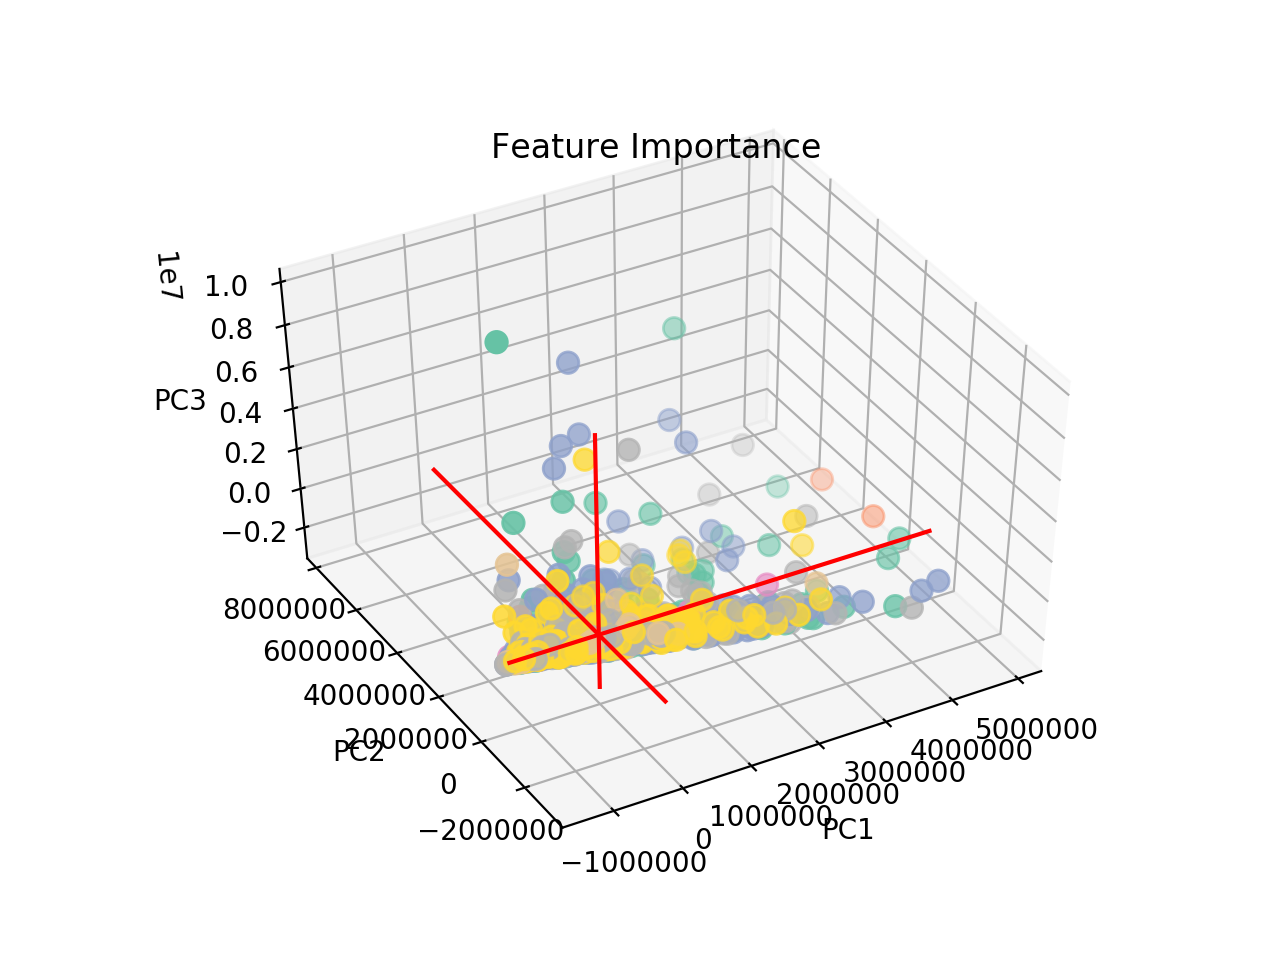

In [36]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

my_dpi=96
# plt.figure(figsize=(480/my_dpi, 480/my_dpi), dpi=my_dpi)
 
pca3 = PCA(n_components = 3).fit_transform(X_train)
df_pca3 = pd.DataFrame(data = pca3 , columns = ['PCA0', 'PCA1', 'PCA2'])

df_pca3['y'] = y_train
df_pca3['y']=pd.Categorical(df_pca3['y'])
my_color=df_pca3['y'].cat.codes
df_pca3 = df_pca3.drop('y', 1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df_pca3['PCA0'], df_pca3['PCA1'], df_pca3['PCA2'], c=my_color, cmap="Set2_r", s=60)

xAxisLine = ((min(df_pca3['PCA0']), max(df_pca3['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(df_pca3['PCA1']), max(df_pca3['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(df_pca3['PCA2']), max(df_pca3['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import KernelPCA

pipe_knn = make_pipeline(StandardScaler(),
                         SelectFromModel(RandomForestClassifier(), threshold=0.001),
                         KernelPCA(),
                         KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski'))

sorted(pipe_knn.get_params().keys())

# gs = GridSearchCV(estimator=pipe_knn,
#                   param_grid=[{'selectfrommodel__estimator__n_estimators': [10, 50, 100, 500, 1000]}
#                              ],
#                   scoring='accuracy',
#                   cv=5)

# gs = gs.fit(X_train, y_train)
# print(gs.best_score_)
# print(gs.best_params_)

['kernelpca',
 'kernelpca__alpha',
 'kernelpca__coef0',
 'kernelpca__copy_X',
 'kernelpca__degree',
 'kernelpca__eigen_solver',
 'kernelpca__fit_inverse_transform',
 'kernelpca__gamma',
 'kernelpca__kernel',
 'kernelpca__kernel_params',
 'kernelpca__max_iter',
 'kernelpca__n_components',
 'kernelpca__n_jobs',
 'kernelpca__random_state',
 'kernelpca__remove_zero_eig',
 'kernelpca__tol',
 'kneighborsclassifier',
 'kneighborsclassifier__algorithm',
 'kneighborsclassifier__leaf_size',
 'kneighborsclassifier__metric',
 'kneighborsclassifier__metric_params',
 'kneighborsclassifier__n_jobs',
 'kneighborsclassifier__n_neighbors',
 'kneighborsclassifier__p',
 'kneighborsclassifier__weights',
 'memory',
 'selectfrommodel',
 'selectfrommodel__estimator',
 'selectfrommodel__estimator__bootstrap',
 'selectfrommodel__estimator__class_weight',
 'selectfrommodel__estimator__criterion',
 'selectfrommodel__estimator__max_depth',
 'selectfrommodel__estimator__max_features',
 'selectfrommodel__estimator__